In [ ]:
#selenium webdriver 
#beautiful soup
#requests 

In [ ]:
#!pip install selenium

In [ ]:
import pandas as pd
import plotly.express as px
from matplotlib import pyplot


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import adfuller


from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


data = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/GOOG?period1=1092873600&period2=1673740800&interval=1d&events=history&includeAdjustedClose=true')

In [ ]:
data['SMA30'] = data['Close'].rolling(30).mean()
data['CMA30'] = data['Close'].expanding().mean()
data['EMA30'] = data['Close'].ewm(span=30).mean()


data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,SMA30,CMA30,EMA30,Diff_Value
4629,2023-01-09,89.195000,90.830002,88.580002,88.800003,88.800003,22996700,92.676333,37.680518,91.424120,0.639999
4630,2023-01-10,86.720001,89.474998,86.699997,89.239998,89.239998,22855600,92.397666,37.691652,91.283209,0.439995
4631,2023-01-11,90.059998,92.449997,89.739998,92.260002,92.260002,25998800,92.264666,37.703432,91.346228,3.020004
4632,2023-01-12,92.400002,92.620003,90.570000,91.910004,91.910004,22754200,92.147000,37.715133,91.382600,-0.349998
4633,2023-01-13,91.528000,92.980003,90.930000,92.800003,92.800003,18617800,91.858667,37.727020,91.474046,0.889999


In [ ]:
fig = px.line(data, x='Date', y=['Close','SMA30','CMA30','EMA30'], title='Google Stock - Historical Daily Close')
fig.show()

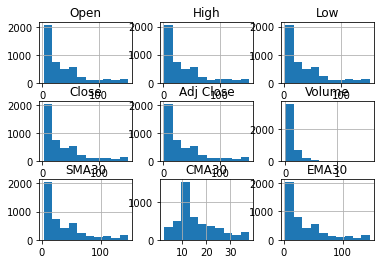

In [ ]:
data.hist()
pyplot.show()

In [ ]:
X = data["Close"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -0.202661
p-value: 0.938204
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Failed to Reject Ho - Time Series is Non-Stationary


In [ ]:
data["Diff_Value"] = data["Close"].diff()
diff_values = data["Diff_Value"].values
Y = diff_values[~np.isnan(diff_values)]

ts_values_orig = data["Close"].values
ts_values = ts_values_orig[:-1]

X = sm.add_constant(ts_values)

model = sm.OLS(Y,X)
results = model.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2842
Date:                Mon, 16 Jan 2023   Prob (F-statistic):              0.594
Time:                        14:38:47   Log-Likelihood:                -6369.4
No. Observations:                4633   AIC:                         1.274e+04
Df Residuals:                    4631   BIC:                         1.276e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0275      0.021      1.336      0.1

In [ ]:
uni_df = data[['Date', 'Close']]

uni_df.dtypes

Date      object
Close    float64
dtype: object

In [ ]:
uni_df['Date'] = uni_df['Date'].apply(pd.to_datetime, errors='coerce')
uni_df.shape

<ipython-input-41-83b10c7ccda4>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Date     datetime64[ns]
Close           float64
dtype: object

In [ ]:
uni_df

,Date,Close
0,2014-03-04,30.259331
1,2014-03-05,30.342768
2,2014-03-06,30.376392
3,2014-03-07,30.256342
4,2014-03-10,30.176142
...,...,...
2229,2023-01-09,88.800003
2230,2023-01-10,89.239998
2231,2023-01-11,92.260002
2232,2023-01-12,91.910004


In [ ]:
def window_df(test_df, cut_off_date, window_size):
  feature_name = 'Target-'
  new_df = pd.DataFrame()
  test_df = test_df.loc[test_df['Date'] > cut_off_date].reset_index(drop=True)
  new_df['Target Date'] = test_df['Date'][window_size:]
  
  i = 0
  new_df.reset_index(inplace=True, drop=True)

  while i  < window_size:
    feature_num = feature_name + str(window_size - i)
    new_df[feature_num] = test_df['Close'][i:].reset_index(drop=True)
    i+=1 

  new_df['Target'] = test_df['Close'][window_size:].reset_index(drop=True)

  return new_df

In [ ]:
windowed_df = window_df(uni_df, '2017-01-01', 7)

windowed_df

,Target Date,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2017-01-12,39.306999,39.345001,39.701000,40.307499,40.332500,40.239498,40.395500,40.318001
1,2017-01-13,39.345001,39.701000,40.307499,40.332500,40.239498,40.395500,40.318001,40.394001
2,2017-01-17,39.701000,40.307499,40.332500,40.239498,40.395500,40.318001,40.394001,40.230499
3,2017-01-18,40.307499,40.332500,40.239498,40.395500,40.318001,40.394001,40.230499,40.303501
4,2017-01-19,40.332500,40.239498,40.395500,40.318001,40.394001,40.230499,40.303501,40.108749
...,...,...,...,...,...,...,...,...,...
1507,2023-01-09,86.459999,88.949997,88.730003,89.699997,88.709999,86.769997,88.160004,88.800003
1508,2023-01-10,88.949997,88.730003,89.699997,88.709999,86.769997,88.160004,88.800003,89.239998
1509,2023-01-11,88.730003,89.699997,88.709999,86.769997,88.160004,88.800003,89.239998,92.260002
1510,2023-01-12,89.699997,88.709999,86.769997,88.160004,88.800003,89.239998,92.260002,91.910004


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1512,), (1512, 7, 1), (1512,))

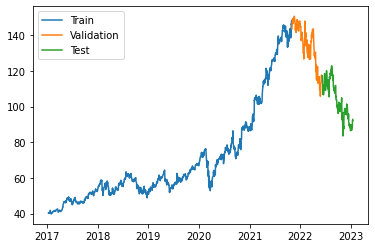

In [ ]:
import matplotlib.pyplot as plt

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((7, 1)),
                    layers.LSTM(256),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=0)

38/38 [==============================] - 1s 9ms/step


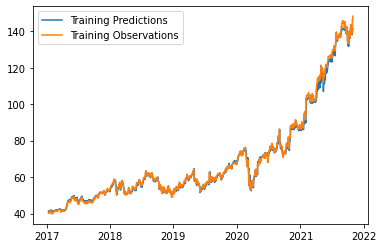

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

5/5 [==============================] - 0s 9ms/step


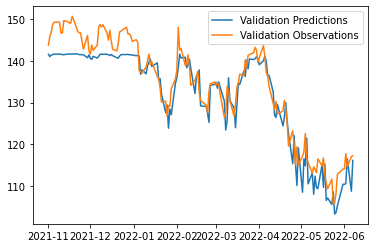

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

5/5 [==============================] - 0s 8ms/step


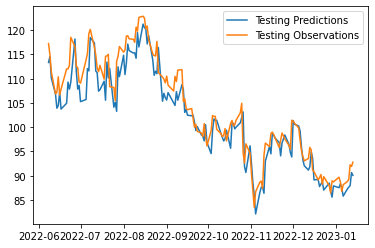

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

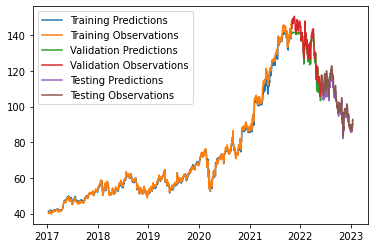

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])